In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow

from datetime import datetime

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pyod.models.lof import LOF 
from pyod.models.iforest import IForest
from pyod.models.mad import MAD
#from pyod.models.auto_encoder import AutoEncoder


In [2]:
data = pd.read_csv('../data/raw/AW_rhr.csv')
data.head()

,Device,Start_Date,Start_Time,Value
0,AppleWatch,2026-01-03,06:13:06,77
1,AppleWatch,2026-01-03,06:13:15,75
2,AppleWatch,2026-01-03,06:26:04,87
3,AppleWatch,2026-01-03,06:26:10,90
4,AppleWatch,2026-01-03,06:29:26,81


In [3]:
data['datetime'] = data['Start_Date'] + ' ' + data['Start_Time']

In [4]:
df = data.drop(columns=['Device', 'Start_Date', 'Start_Time'])

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year.astype(str)
df['month'] = df['datetime'].dt.month.astype(str)
df['day'] = df['datetime'].dt.day.astype(str)

In [8]:
df_day_min = df.groupby(['year', 'month', 'day'])['Value'].agg('idxmin').reset_index()
df_day_min = df_day_min.sort_values('Value').reset_index()
df_day_min = df_day_min.rename(columns= {'Value': 'index of min'})
#df_day_min.drop(columns=['index'], inplace=True)

In [14]:
time = 1000
df_final = pd.DataFrame({'Time': [], 'Temp': []})

for i in df_day_min.index:
    #find the index of the local minimum for the day as location. 
    location = df.loc[df.index == df_day_min['index of min'][i]].index.to_numpy()
    #Take a mean of of the temperatures before and after the min according to 'time'
    df_final.loc[i] = str(df['datetime'].loc[location]).split()[1] + ' ' + str(df['datetime'].loc[location]).split()[2], round(df['Value'].iloc[int(location)-time:int(location)+time].mean(), 2)
    #Take the time of the min value.
    #df_final['Time'].loc[i] = df['datetime'].loc[location]
    
df_final

,Time,Temp
0,2026-01-03 10:15:35,NaN
1,2026-01-04 09:57:55,NaN
2,2026-01-05 09:48:36,NaN
3,2026-01-06 20:09:14,72.93
4,2026-01-07 01:49:14,72.49
...,...,...
107,2026-04-21 05:02:57,92.18
108,2026-04-22 06:26:57,87.08
109,2026-04-23 09:09:34,84.61
110,2026-04-24 17:12:46,85.04


In [15]:
df_final.dropna(inplace=True)

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


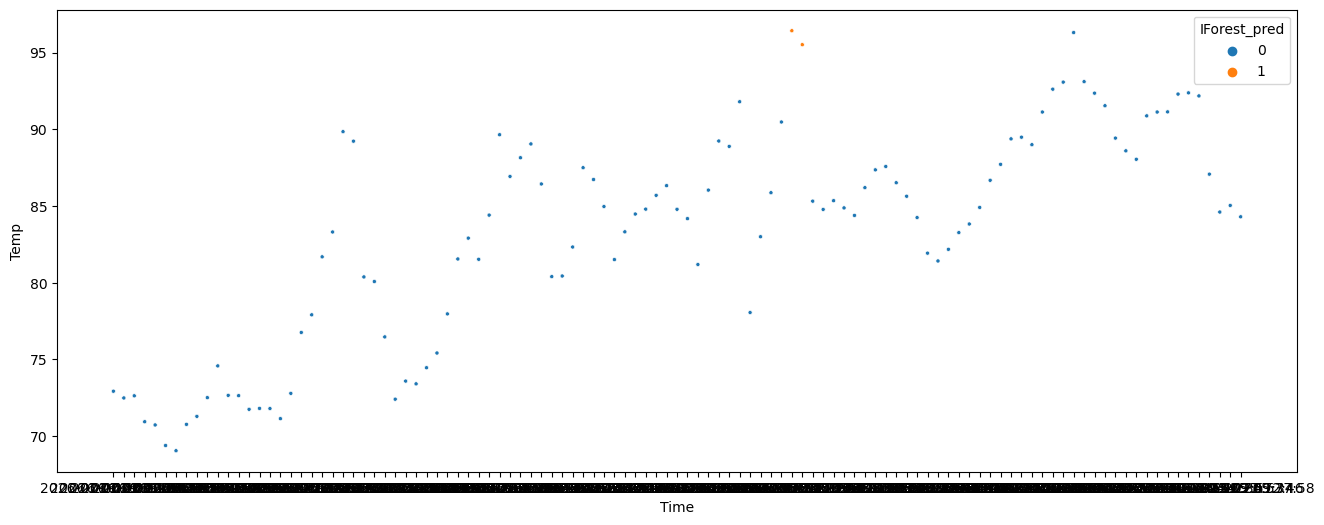

In [16]:
model = IForest(contamination=0.01)
df_final['IForest_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='IForest_pred', marker=".");

In [21]:
outlier_date = df_final.loc[df_final['IForest_pred'] == 1]
outlier_date

,Time,Temp,IForest_pred,LOF_pred,MAD_pred
68,2026-03-12 21:22:50,96.43,1,1,0
69,2026-03-13 07:22:23,95.52,1,1,0


/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


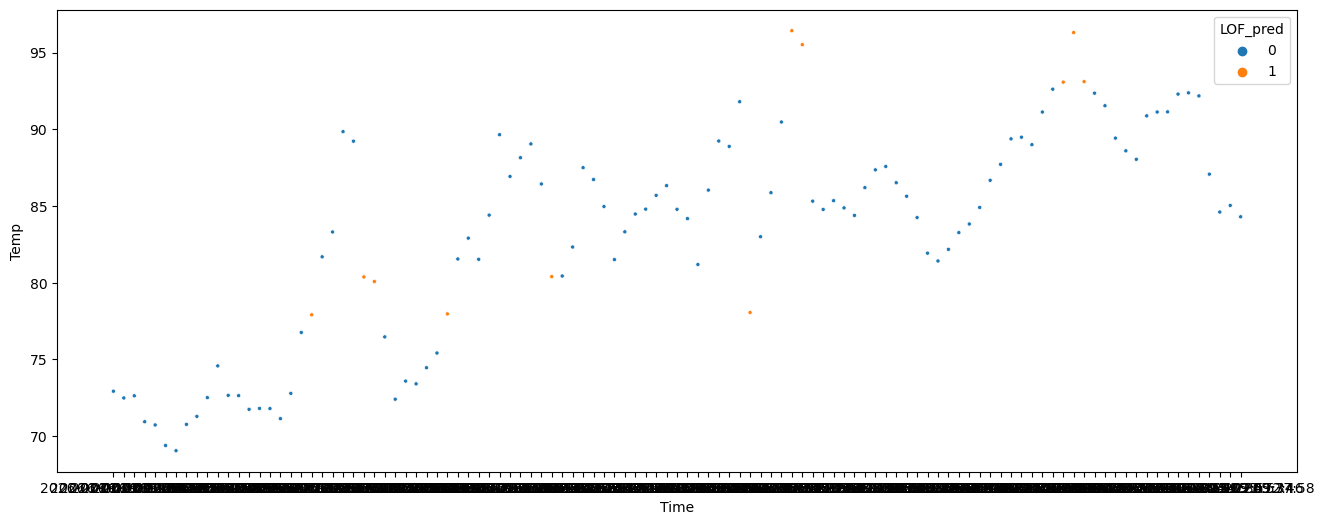

In [17]:
model = LOF()
df_final['LOF_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='LOF_pred', marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


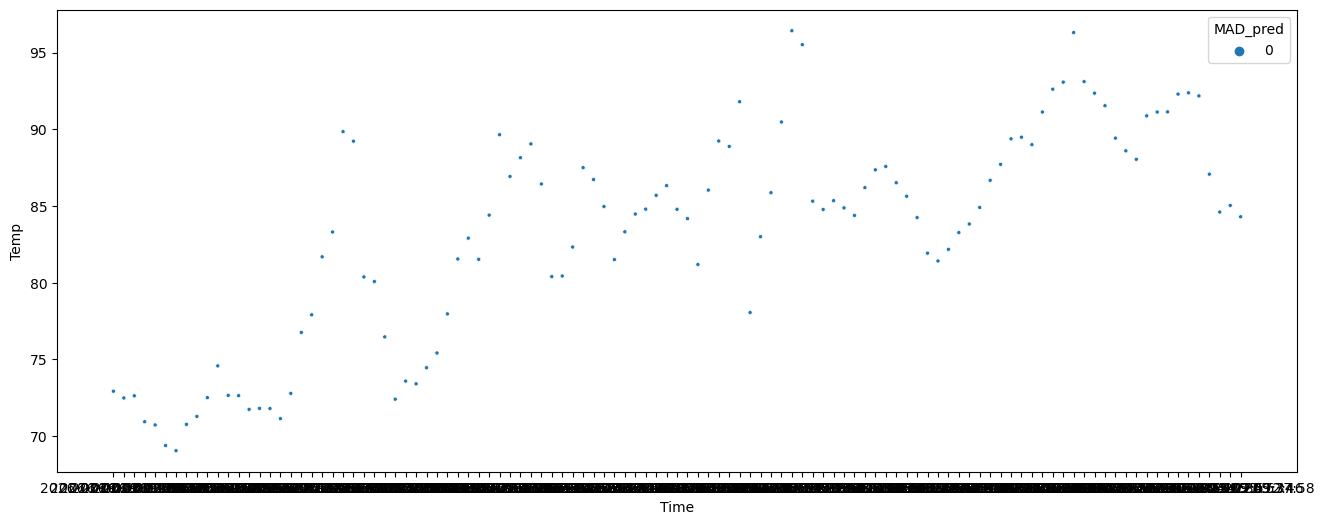

In [18]:
model = MAD()
df_final['MAD_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='MAD_pred', marker=".");